In [1]:
import cv2 , tqdm, os, glob, string
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
files = glob.glob("export2/train/*")
tr_dirs = glob.glob("data/train/*")
tr_df = pd.concat([pd.read_csv(f"{i}/label.csv") for i in tr_dirs], ignore_index=True)
tr_df["img_name"] = [f"export2/train/{i}" for i in tr_df["img_name"]]
te_df = pd.DataFrame({"img_name":glob.glob("export2/test/*")})
te_df = pd.read_csv("data/sample_submission.csv")
te_df["img_name"] = [f"export2/test/{i}" for i in te_df["img_name"]]

In [3]:
tr_df

,img_name,leaf_weight
0,export2/train/CASE23_01.jpg,51.392
1,export2/train/CASE23_02.jpg,61.783
2,export2/train/CASE23_03.jpg,123.205
3,export2/train/CASE23_04.jpg,169.785
4,export2/train/CASE23_05.jpg,192.064
...,...,...
1587,export2/train/CASE19_01.jpg,0.026
1588,export2/train/CASE19_02.jpg,0.290
1589,export2/train/CASE19_03.jpg,0.578
1590,export2/train/CASE19_04.jpg,0.747


In [4]:
def preprocessing(row, is_test=False):
    x = cv2.imread(row[0])
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

    H, W = x.shape[:2]
    
    max_HW = np.max([H,W])
    new_x = np.zeros((max_HW,max_HW,3))
    new_x[:] = 255
    center = max_HW//2
    lower = center - np.min([H,W])//2
    upper = center + np.min([H,W])//2
    
    new_x[lower:upper] = x
    new_x = cv2.resize(new_x, (224,224))
    new_x = new_x.astype(float)
    y = row[1]
    if is_test:
        return new_x
    return new_x, y

In [5]:
class MyGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, preprocessing, aug_fun=None, is_test=False):
        self.data = df
        self.batch_size = batch_size 
        self.preprocessing = preprocessing
        self.aug_fun = aug_fun
        self.is_test = is_test
    def __len__(self):
        return np.ceil(self.data.shape[0] / self.batch_size).astype(int)
    def __getitem__(self, index):
        st = index * self.batch_size
        ed = (index + 1) * self.batch_size
        paths = self.data.values[st:ed]
        x_list = []
        y_list = []
        for file_path in paths:
            if self.is_test:
                x = self.preprocessing(file_path, self.is_test)
            else:
                x, y = self.preprocessing(file_path)
            if self.aug_fun:
                x = self.aug_fun(image= x)["image"]
                x = np.clip(x, 0, 255)
            x_list.append(x)
            if not self.is_test:
                y_list.append(y)
        bat_x = np.array(x_list)
        if self.is_test:
            return bat_x
        bat_y = np.array(y_list)
        return bat_x, bat_y
    def on_epoch_end(self):
        self.data = self.data.sample(frac = 1)

In [6]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    backbone = tf.keras.applications.MobileNetV2(
        input_shape=(224,224,3), include_top=False)
    backbone.trainable = True
    x = backbone(x)
    gap = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512)(gap)
    x = tf.keras.layers.Dense(128)(x)
    output = tf.keras.layers.Dense(1, activation="ReLU")(x)    
    model = tf.keras.Model(inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=1 * 1e-3)
    
    model.compile(
        optimizer = opt,
        loss = "MSE",
        metrics="MAE"
        )
    return model

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # 검증 손실 기준
    factor=0.5,            # 학습률 줄이는 비율 (50%)
    patience=6,            # 개선 없을 시 3 에폭 기다림
    verbose=1,
    min_lr=1e-7
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,            # 7 에폭 동안 개선 없으면 중단
    verbose=1,
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stop]

In [8]:
my_bins = [0, 20, 100, 200, 300, 1000] 
tr_df['leaf_weight_bin'] = pd.cut(
    tr_df['leaf_weight'], bins=my_bins, 
    labels=False, include_lowest=True)

In [9]:
augs = [
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(blur_limit=5, p=.6),
    A.Affine(
        # scale=(0.9, 1.1), # 줌 할 예정이라 제외
        translate_percent=(0.01, 0.02),
        rotate=(-5, 5),
        fill=255,
        p=0.8, 
    ),
]
aug_fun = A.Compose(augs)

In [10]:
train_df, val_df = train_test_split(
    tr_df, test_size=0.1, 
    stratify=tr_df["leaf_weight_bin"],
    random_state=42
)
batch_size = 16
tr_gen = MyGenerator(train_df.reset_index(drop=True), 
                 batch_size, preprocessing, aug_fun=aug_fun)
val_gen = MyGenerator(val_df.reset_index(drop=True), 
                 batch_size, preprocessing, aug_fun=None)
checkpoint_path = f'model/model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False  
)
model = create_model()

2025-09-28 12:12:50.976203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-28 12:12:50.987085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-28 12:12:50.989946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-28 12:12:50.993036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
history = model.fit(
    tr_gen,
    validation_data= val_gen,
    epochs=100,
    callbacks=[*callbacks, checkpoint],
    use_multiprocessing=True,
    workers=4
    )
model.load_weights(checkpoint_path)

Epoch 1/100


2025-09-28 12:13:04.159416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2025-09-28 12:13:07.402720: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/90 [======>.......................] - ETA: 26s - loss: 3048.7043 - MAE: 30.9402  

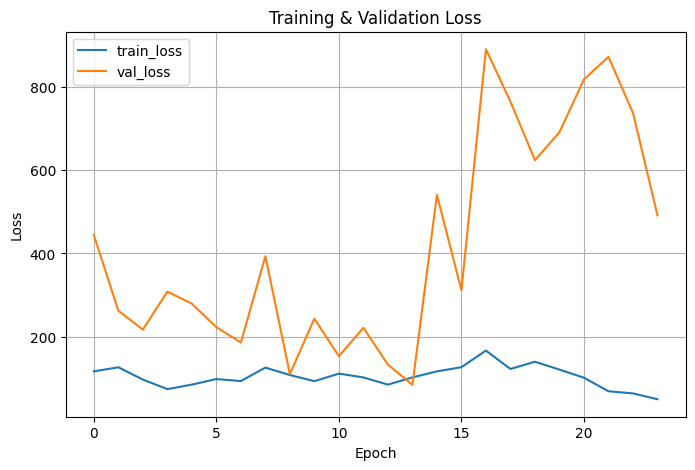

In [16]:
hist = history.history

# 1. Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(hist['loss'][30:], label='train_loss')
plt.plot(hist['val_loss'][30:], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
te_gen = MyGenerator(
    te_df, batch_size, preprocessing,
    aug_fun=None, is_test=True)
pred = model.predict(te_gen,verbose=1)

29/29 [==============================] - 4s 111ms/step


In [22]:
te_df["leaf_weight"] = pred

In [30]:
te_df["img_name"] = [os.path.basename(i) for i in te_df["img_name"]]

In [31]:
te_df[["img_name","leaf_weight"]].to_csv(
    "results/00_first.csv",index=False)